# NBS --> All Scans | Different Design Matrix Configurations

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import os.path as osp
import os
from tqdm import tqdm
from shutil import rmtree
import seaborn as sns
import matplotlib.pyplot as plt
from utils.plotting import hvplot_fc
from scipy.spatial.distance import squareform
from utils.basics import SNYCQ_W_PATH, SNYCQ_CLUSTERS_INFO_PATH, RESOURCES_DINFO_DIR,RESOURCES_NBS_DIR, ATLASES_DIR, DATA_DIR, PRJ_DIR
from utils.basics import FB_400ROI_ATLAS_NAME as ATLAS_NAME
from sfim_lib.io.afni import load_netcc
import panel as pn
FINAL_SCAN_LISTS = {}

In [2]:
from sklearn.preprocessing import OneHotEncoder
import hvplot.pandas

In [3]:
import os
port_tunnel = int(os.environ['PORT2'])
print('++ INFO: Second Port available: %d' % port_tunnel)

++ INFO: Second Port available: 44187


# 1. Load Information about scans
Load ROI information: label, hemisphere, etc..

In [4]:
ATLASINFO_PATH = osp.join(ATLASES_DIR,ATLAS_NAME,'{ATLAS_NAME}.roi_info.csv'.format(ATLAS_NAME=ATLAS_NAME))
roi_info       = pd.read_csv(ATLASINFO_PATH)
Nrois          = roi_info.shape[0]

Load x,y on low dimensional space for each scan

In [5]:
W = pd.read_csv(SNYCQ_W_PATH,index_col=['Subject','Run'])

Load cluster membershipt for each scan

In [6]:
clusters_info = pd.read_csv(SNYCQ_CLUSTERS_INFO_PATH, index_col=['Subject','Run'])

Load motion information for each scan

In [7]:
mot_info = pd.read_csv(osp.join(RESOURCES_DINFO_DIR,'motion_confounds.csv'),index_col=['Subject','Run'])

Combine all info we have about the scans into a single dataframe

In [8]:
SCAN_INFO_df = pd.concat([W,clusters_info,mot_info],axis=1)
SCAN_INFO_df.head(2)

Factor 1  Factor 2  Cluster ID  \
Subject    Run                                                         
sub-010014 post-ses-02-run-01-acq-AP  0.842570  0.621762           3   
           post-ses-02-run-01-acq-PA  0.861308  0.890006           3   

                                     Cluster Label  Mean Rel Motion  
Subject    Run                                                       
sub-010014 post-ses-02-run-01-acq-AP  Intermediate         0.090026  
           post-ses-02-run-01-acq-PA  Intermediate         0.062215

<Axes: xlabel='Factor 1', ylabel='Factor 2'>

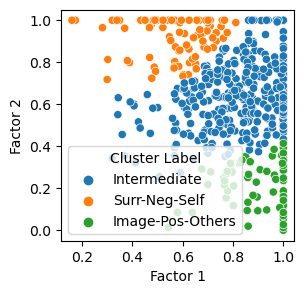

In [9]:
plt.subplots(1,1,figsize=(3,3))
sns.scatterplot(data=SCAN_INFO_df,x='Factor 1',y='Factor 2', hue='Cluster Label')

Remove scans in intermediate cluster

<Axes: xlabel='Factor 1', ylabel='Factor 2'>

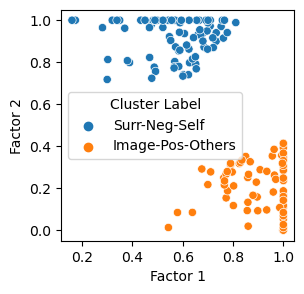

In [10]:
SCAN_INFO_df = SCAN_INFO_df[SCAN_INFO_df['Cluster Label'] != 'Intermediate']
plt.subplots(1,1,figsize=(3,3))
sns.scatterplot(data=SCAN_INFO_df,x='Factor 1',y='Factor 2', hue='Cluster Label')

In [11]:
del mot_info, clusters_info, W

Show some basic information for the selected list of scans

In [12]:
ORIG_N_scans = SCAN_INFO_df.index.get_level_values('Subject').shape[0]
ORIG_N_sbjs  = SCAN_INFO_df.index.get_level_values('Subject').unique().shape[0]
print('++ Number of scans across both clustes: %d scans' % ORIG_N_scans)
print('++ Number of subjects across both clusters: %d subjects' % ORIG_N_sbjs)
print('++ Number of scans per cluster')
SCAN_INFO_df['Cluster Label'].value_counts()

++ Number of scans across both clustes: 159 scans
++ Number of subjects across both clusters: 83 subjects
++ Number of scans per cluster


Image-Pos-Others    81
Surr-Neg-Self       78
Name: Cluster Label, dtype: int64

***
# 4. Load the FC matrices for all scans in an Xarray

This xarray will be indexed by ```<SBJ>.<SCAN>``` on the scan dimension

In [13]:
%%time
# Create Empty Numpy Array where to hold all FC matrices. At the end we will move this into an Xarray
# ===================================================================================================
sfc_Z_arr      = np.empty((ORIG_N_scans,Nrois,Nrois)) * np.nan
print('++ INFO: Shape of final Xarray: %s' % str(sfc_Z_arr.shape))
i              = 0  # Index to move through the scan dimension numerically
xr_coords_scan = [] # List of scan IDs to later use as the coordinates for the scan dimension

# For each scan in a given cluster
# ================================
for (sbj,run),_ in tqdm(SCAN_INFO_df.iterrows()):
    # Load FC matrix from disk
    # ========================
    xr_coords_scan.append('.'.join([sbj,run])) 
    _,_,sesID,_,runID,_,acqID = run.split('-')
    sfc_path = osp.join(DATA_DIR,'PrcsData',sbj,'preprocessed','func','pb06_staticFC','{acqID}_run-{runID}.{ATLAS_NAME}_000.netcc'.format(acqID=acqID,runID=runID, ATLAS_NAME=ATLAS_NAME))
    aux_cc_r = load_netcc(sfc_path)
    # Apply Fisher's transformation
    # =============================
    aux_cc_Z = aux_cc_r.apply(np.arctanh)
    np.fill_diagonal(aux_cc_Z.values,1)
    sfc_Z_arr[i,:,:] = aux_cc_Z
    # Update counter
    # ==============
    i = i + 1
    del aux_cc_r, aux_cc_Z

# Save all FC matrixes for a given atlas in XR.Array Form
# =======================================================
sfc_Z_xr = xr.DataArray(sfc_Z_arr,
                    dims=['scan','roi_x','roi_y'],
                    coords={'scan':xr_coords_scan ,
                            'roi_x':roi_info['ROI_ID'],
                            'roi_y':roi_info['ROI_ID']})
del sfc_Z_arr

++ INFO: Shape of final Xarray: (159, 380, 380)


159it [00:04, 38.81it/s]

CPU times: user 3.92 s, sys: 293 ms, total: 4.21 s
Wall time: 4.24 s


***
# 5. Compute mean per subject/cluster

In [14]:
SCAN_INFO_df = SCAN_INFO_df.reset_index().set_index(['Subject','Run','Cluster Label'])
SCAN_INFO_df.head(3)

Factor 1  Factor 2  \
Subject    Run                       Cluster Label                          
sub-010014 post-ses-02-run-02-acq-AP Surr-Neg-Self     0.709076  0.972487   
           post-ses-02-run-02-acq-PA Surr-Neg-Self     0.680004  0.938335   
sub-010080 post-ses-02-run-02-acq-PA Image-Pos-Others  1.000000  0.400438   

                                                       Cluster ID  \
Subject    Run                       Cluster Label                  
sub-010014 post-ses-02-run-02-acq-AP Surr-Neg-Self              2   
           post-ses-02-run-02-acq-PA Surr-Neg-Self              2   
sub-010080 post-ses-02-run-02-acq-PA Image-Pos-Others           1   

                                                       Mean Rel Motion  
Subject    Run                       Cluster Label                      
sub-010014 post-ses-02-run-02-acq-AP Surr-Neg-Self            0.087601  
           post-ses-02-run-02-acq-PA Surr-Neg-Self            0.070103  
sub-010080 post-ses-02-run-02-acq-PA Image-Pos-Others         0.092674

In [15]:
SCAN_LIST = list(sfc_Z_xr.scan.values)
SBJ_LIST  = [item.split('.')[0] for item in SCAN_LIST]
SBJ_LIST_NOREPS = []
for sbj in SBJ_LIST:
    if sbj not in SBJ_LIST_NOREPS:
        SBJ_LIST_NOREPS.append(sbj)
CLUSTER_LIST = list(SCAN_INFO_df.index.get_level_values('Cluster Label').unique())
print('FINAL_SCAN_LIST:       %s' % str(SCAN_LIST[0:6]))
print('FINAL_SBJ_LIST:        %s' % str(SBJ_LIST[0:10]))
print('FINAL_SBJ_LIST_NOREPS: %s' % str(SBJ_LIST_NOREPS[0:10]))
print('CLUSTER_LIST:          %s' % str(CLUSTER_LIST))

FINAL_SCAN_LIST:       ['sub-010014.post-ses-02-run-02-acq-AP', 'sub-010014.post-ses-02-run-02-acq-PA', 'sub-010080.post-ses-02-run-02-acq-PA', 'sub-010082.post-ses-02-run-01-acq-AP', 'sub-010082.post-ses-02-run-01-acq-PA', 'sub-010015.post-ses-02-run-01-acq-AP']
FINAL_SBJ_LIST:        ['sub-010014', 'sub-010014', 'sub-010080', 'sub-010082', 'sub-010082', 'sub-010015', 'sub-010015', 'sub-010015', 'sub-010015', 'sub-010094']
FINAL_SBJ_LIST_NOREPS: ['sub-010014', 'sub-010080', 'sub-010082', 'sub-010015', 'sub-010094', 'sub-010096', 'sub-010017', 'sub-010098', 'sub-010099', 'sub-010101']
CLUSTER_LIST:          ['Surr-Neg-Self', 'Image-Pos-Others']


In [16]:
FINAL_INDEX_LIST = []
for (sbj,run,cl),row in SCAN_INFO_df.iterrows():
    idx = sbj+'.'+cl
    if idx not in FINAL_INDEX_LIST:
        FINAL_INDEX_LIST.append(idx)
FINAL_N_samples = len(FINAL_INDEX_LIST)
print('++ Number of samples going to NBS --> %d samples' % FINAL_N_samples)
print('FINAL_INDEX_LIST: %s' % str(FINAL_INDEX_LIST[0:6]))

++ Number of samples going to NBS --> 90 samples
FINAL_INDEX_LIST: ['sub-010014.Surr-Neg-Self', 'sub-010080.Image-Pos-Others', 'sub-010082.Surr-Neg-Self', 'sub-010015.Surr-Neg-Self', 'sub-010094.Surr-Neg-Self', 'sub-010096.Surr-Neg-Self']


In [17]:
sfc_Z_arr_means = np.empty((FINAL_N_samples,Nrois,Nrois)) * np.nan
print('++ INFO: Shape of final Xarray (Means): %s' % str(sfc_Z_arr_means.shape))
i = 0
for idx in tqdm(FINAL_INDEX_LIST):
    # Separate sbj and cluster strings
    sbj,cl        = idx.split('.')
    # Find all the scans from this <sbj> that are labeled as <cl>
    aux           = SCAN_INFO_df.loc[sbj,:,cl]
    # Built a list with <sbj>.<scan> with everything identified in the line above (might be 1 or more than 1 scan depending on subject/cluster combination)
    aux_selector  = [sbj+'.'+i for i in aux.index]
    # Select FC matrixes for those scans and average them.
    aux            = sfc_Z_xr.loc[aux_selector].mean(axis=0).values
    # Place the mean matrix in the new Xrarray matrix
    sfc_Z_arr_means[i,:,:] = aux
    i = i + 1
# Save all FC matrixes for a given atlas in XR.Array Form
# =======================================================
sfc_Z_means_xr = xr.DataArray(sfc_Z_arr_means,
                    dims=['scan','roi_x','roi_y'],
                    coords={'scan':FINAL_INDEX_LIST,
                            'roi_x':roi_info['ROI_ID'],
                            'roi_y':roi_info['ROI_ID']})
del sfc_Z_arr_means

++ INFO: Shape of final Xarray (Means): (90, 380, 380)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 174.55it/s]


In [21]:
sfc_Z_means_xr.head(3)

<xarray.DataArray (scan: 3, roi_x: 3, roi_y: 3)>
array([[[1.        , 0.79102835, 0.7016214 ],
        [0.79102835, 1.        , 0.48543766],
        [0.7016214 , 0.48543766, 1.        ]],

       [[1.        , 0.73038364, 0.73038364],
        [0.73038364, 1.        , 0.4110926 ],
        [0.73038364, 0.4110926 , 1.        ]],

       [[1.        , 0.58066931, 0.70186583],
        [0.58066931, 1.        , 0.39435529],
        [0.70186583, 0.39435529, 1.        ]]])
Coordinates:
  * scan     (scan) <U27 'sub-010014.Surr-Neg-Self' ... 'sub-010082.Surr-Neg-...
  * roi_x    (roi_x) int64 1 2 3
  * roi_y    (roi_y) int64 1 2 3

In [22]:
NBS_OUTPUT_DIR = osp.join(RESOURCES_NBS_DIR,ATLAS_NAME,'Mean_Scans')

In [24]:
if osp.exists(NBS_OUTPUT_DIR):
    #rmtree(NBS_OUTPUT_DIR )
    print('++ WARNING: This folder already exists!!!!!! pre-existing folder [%s]' % NBS_OUTPUT_DIR )
else:
    os.makedirs(NBS_OUTPUT_DIR )
    print('++ INFO: Creating new folder [%s]' % NBS_OUTPUT_DIR )

++ WARNING: This folder already exists!!!!!! pre-existing folder [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nbs/Schaefer2018_400Parcels_7Networks_AAL2/Mean_Scans]


In [25]:
DESING_MATRIX_PATH       = osp.join(NBS_OUTPUT_DIR,'NBS_CL02_DesingMatrix.txt')
NBS_CL02_matrices_folder = osp.join(NBS_OUTPUT_DIR,'NBS_CL02_Data')
if osp.exists(NBS_CL02_matrices_folder):
    print('++ WARNING: Removing folder with FC matrices [%s]' % NBS_CL02_matrices_folder)
    rmtree(NBS_CL02_matrices_folder)
print('INFO: Regenerating empty FC matrix folder [%s]' % NBS_CL02_matrices_folder)
os.makedirs(NBS_CL02_matrices_folder)

with open(DESING_MATRIX_PATH, 'w') as the_file:
    for i,idx in enumerate(FINAL_INDEX_LIST):
        dest_path = osp.join(NBS_CL02_matrices_folder,'subject{id}.txt'.format(id=str(i+1).zfill(3)))
        np.savetxt(dest_path,sfc_Z_means_xr.loc[idx,:,:],delimiter=' ',fmt='%f')
        cl = idx.split('.')[1]
        if cl == 'Image-Pos-Others':
            the_file.write('1 1\n')
        else:
            the_file.write('1 0\n')
the_file.close()

INFO: Regenerating empty FC matrix folder [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nbs/Schaefer2018_400Parcels_7Networks_AAL2/Mean_Scans/NBS_CL02_Data]


In [26]:
DESING_MATRIX = np.loadtxt(DESING_MATRIX_PATH)

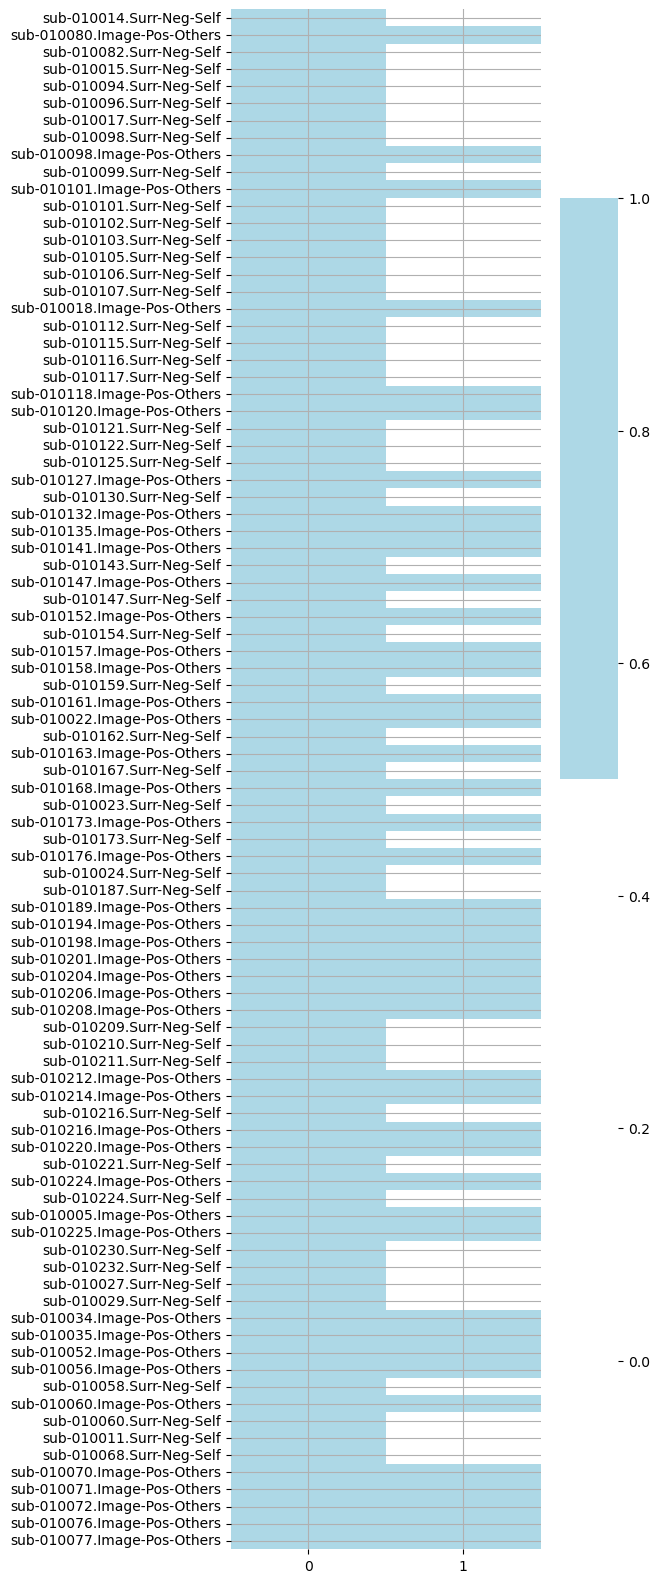

In [34]:
fig, ax = plt.subplots(1,1,figsize=(5,20))
sns.heatmap(DESING_MATRIX, yticklabels=FINAL_INDEX_LIST, cmap=['white','lightblue'])
plt.grid('on')

# Current Status of results (Oct 26th 2023)

* When running NBS using the mean scan approach:

    * Nothing survives at  T > 3.1 in either direction
    

***

5. Compact across subjects/cluster

In some instances, we will have more than one scan per subject/cluster. One thing we can do is to average them

In [15]:
aux = SELECTED_SCANS.reset_index().set_index(['Subject','Run','Cluster Label'])
aux.head(5)

Factor 1  Factor 2  \
Subject    Run                       Cluster Label                          
sub-010014 post-ses-02-run-02-acq-AP Surr-Neg-Self     0.709076  0.972487   
           post-ses-02-run-02-acq-PA Surr-Neg-Self     0.680004  0.938335   
sub-010080 post-ses-02-run-02-acq-PA Image-Pos-Others  1.000000  0.400438   
sub-010082 post-ses-02-run-01-acq-AP Surr-Neg-Self     0.696976  0.948900   
           post-ses-02-run-01-acq-PA Surr-Neg-Self     0.627213  0.797629   

                                                       Cluster ID  \
Subject    Run                       Cluster Label                  
sub-010014 post-ses-02-run-02-acq-AP Surr-Neg-Self              2   
           post-ses-02-run-02-acq-PA Surr-Neg-Self              2   
sub-010080 post-ses-02-run-02-acq-PA Image-Pos-Others           1   
sub-010082 post-ses-02-run-01-acq-AP Surr-Neg-Self              2   
           post-ses-02-run-01-acq-PA Surr-Neg-Self              2   

                                                       Mean Rel Motion  
Subject    Run                       Cluster Label                      
sub-010014 post-ses-02-run-02-acq-AP Surr-Neg-Self            0.087601  
           post-ses-02-run-02-acq-PA Surr-Neg-Self            0.070103  
sub-010080 post-ses-02-run-02-acq-PA Image-Pos-Others         0.092674  
sub-010082 post-ses-02-run-01-acq-AP Surr-Neg-Self            0.116003  
           post-ses-02-run-01-acq-PA Surr-Neg-Self            0.071737

In [16]:
sbj_list     = aux.index.get_level_values('Subject').unique()
cluster_list = aux.index.get_level_values('Cluster Label').unique()
idx_list     = []
for (sbj,run,cl),row in aux.iterrows():
    idx = sbj+'.'+cl
    if idx not in idx_list:
        idx_list.append(idx)
Nsamples = len(idx_list)
print('++ Number of samples going to NBS --> %d samples' % Nsamples)

++ Number of samples going to NBS --> 90 samples


In [17]:
sfc_Z_arr_means = np.empty((Nsamples,Nrois,Nrois)) * np.nan
print(sfc_Z_arr_means.shape)
idx_i = 0
for idx in idx_list:
    sbj,cl = idx.split('.')
    aux2          = aux.loc[sbj,:,cl]
    aux2_selector = [sbj+'.'+i for i in aux2.index]
    aux3          = sfc_Z_xr.loc[aux2_selector].mean(axis=0).values
    sfc_Z_arr_means[idx_i,:,:] = aux3
    idx_i = idx_i + 1

(90, 380, 380)


In [18]:
sfc_Z_means_xr = xr.DataArray(sfc_Z_arr_means,
                    dims=['scan','roi_x','roi_y'],
                    coords={'scan':idx_list,
                            'roi_x':roi_info['ROI_ID'],
                            'roi_y':roi_info['ROI_ID']})
del sfc_Z_arr_means

In [19]:
sfc_Z_means_xr

<xarray.DataArray (scan: 90, roi_x: 380, roi_y: 380)>
array([[[ 1.        ,  0.79102835,  0.7016214 , ...,  0.05558116,
          0.03022558,  0.31569107],
        [ 0.79102835,  1.        ,  0.48543766, ..., -0.0215212 ,
         -0.01090074,  0.19881778],
        [ 0.7016214 ,  0.48543766,  1.        , ...,  0.03632026,
          0.01310099,  0.33125903],
        ...,
        [ 0.05558116, -0.0215212 ,  0.03632026, ...,  1.        ,
          0.31893049,  0.70986604],
        [ 0.03022558, -0.01090074,  0.01310099, ...,  0.31893049,
          1.        ,  0.3446456 ],
        [ 0.31569107,  0.19881778,  0.33125903, ...,  0.70986604,
          0.3446456 ,  1.        ]],

       [[ 1.        ,  0.73038364,  0.73038364, ..., -0.15421091,
          0.0018    , -0.07916496],
        [ 0.73038364,  1.        ,  0.4110926 , ..., -0.05094403,
          0.09004256,  0.02830756],
        [ 0.73038364,  0.4110926 ,  1.        , ..., -0.17578861,
         -0.02500521, -0.0017    ],
...
        [ 0.16971077, -0.00950029,  0.11865371, ...,  1.        ,
          0.19223343,  0.09518644],
        [ 0.06177847, -0.01190056,  0.08047326, ...,  0.19223343,
          1.        ,  0.07021516],
        [ 0.22365611,  0.05004173,  0.29954918, ...,  0.09518644,
          0.07021516,  1.        ]],

       [[ 1.        ,  0.45601591,  0.57745723, ...,  0.15565679,
          0.08528005,  0.26483018],
        [ 0.45601591,  1.        ,  0.47859158, ...,  0.09709421,
          0.01861488,  0.23879723],
        [ 0.57745723,  0.47859158,  1.        , ...,  0.13213388,
          0.12775716,  0.34391755],
        ...,
        [ 0.15565679,  0.09709421,  0.13213388, ...,  1.        ,
          0.26260719,  0.37682804],
        [ 0.08528005,  0.01861488,  0.12775716, ...,  0.26260719,
          1.        ,  0.1850254 ],
        [ 0.26483018,  0.23879723,  0.34391755, ...,  0.37682804,
          0.1850254 ,  1.        ]]])
Coordinates:
  * scan     (scan) <U27 'sub-010014.Surr-Neg-Self' ... 'sub-010077.Image-Pos...
  * roi_x    (roi_x) int64 1 2 3 4 5 6 7 8 9 ... 373 374 375 376 377 378 379 380
  * roi_y    (roi_y) int64 1 2 3 4 5 6 7 8 9 ... 373 374 375 376 377 378 379 380

In [20]:
NBS_OUTPUT_DIR = osp.join(RESOURCES_NBS_DIR,ATLAS_NAME,f'{FINAL_SELECTION}_Means')

In [21]:
if osp.exists(NBS_OUTPUT_DIR):
    #rmtree(NBS_OUTPUT_DIR )
    print('++ WARNING: This folder already exists!!!!!! pre-existing folder [%s]' % NBS_OUTPUT_DIR )
else:
    os.makedirs(NBS_OUTPUT_DIR )
    print('++ INFO: Regenerating empty folder [%s]' % NBS_OUTPUT_DIR )

++ WARNING: This folder already exists!!!!!! pre-existing folder [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nbs/Schaefer2018_400Parcels_7Networks_AAL2/All_Scans_Means]


In [25]:
DESING_MATRIX_PATH       = osp.join(NBS_OUTPUT_DIR,'NBS_CL02_DesingMatrix.txt')
NBS_CL02_matrices_folder = osp.join(NBS_OUTPUT_DIR,'NBS_CL02_Data')
if osp.exists(NBS_CL02_matrices_folder):
    rmtree(NBS_CL02_matrices_folder)
os.makedirs(NBS_CL02_matrices_folder)
with open(DESING_MATRIX_PATH, 'w') as the_file:
    for i,idx in enumerate(idx_list):
        dest_path = osp.join(NBS_CL02_matrices_folder,'subject{id}.txt'.format(id=str(i+1).zfill(3)))
        np.savetxt(dest_path,sfc_Z_means_xr.loc[idx,:,:],delimiter=' ',fmt='%f')
        cl = idx.split('.')[1]
        if cl == 'Image-Pos-Others':
            the_file.write('1 1\n')
        else:
            the_file.write('1 0\n')
the_file.close()

Factor 1  Factor 2  \
Subject    Run                       Cluster Label                          
sub-010014 post-ses-02-run-02-acq-AP Surr-Neg-Self     0.709076  0.972487   
           post-ses-02-run-02-acq-PA Surr-Neg-Self     0.680004  0.938335   
sub-010080 post-ses-02-run-02-acq-PA Image-Pos-Others  1.000000  0.400438   
sub-010082 post-ses-02-run-01-acq-AP Surr-Neg-Self     0.696976  0.948900   
           post-ses-02-run-01-acq-PA Surr-Neg-Self     0.627213  0.797629   
...                                                         ...       ...   
sub-010072 post-ses-02-run-02-acq-PA Image-Pos-Others  0.777140  0.279428   
sub-010076 post-ses-02-run-01-acq-AP Image-Pos-Others  0.963301  0.385111   
sub-010077 post-ses-02-run-01-acq-AP Image-Pos-Others  0.934441  0.280481   
           post-ses-02-run-01-acq-PA Image-Pos-Others  0.835110  0.334411   
           post-ses-02-run-02-acq-AP Image-Pos-Others  0.766250  0.234898   

                                                       Cluster ID  \
Subject    Run                       Cluster Label                  
sub-010014 post-ses-02-run-02-acq-AP Surr-Neg-Self              2   
           post-ses-02-run-02-acq-PA Surr-Neg-Self              2   
sub-010080 post-ses-02-run-02-acq-PA Image-Pos-Others           1   
sub-010082 post-ses-02-run-01-acq-AP Surr-Neg-Self              2   
           post-ses-02-run-01-acq-PA Surr-Neg-Self              2   
...                                                           ...   
sub-010072 post-ses-02-run-02-acq-PA Image-Pos-Others           1   
sub-010076 post-ses-02-run-01-acq-AP Image-Pos-Others           1   
sub-010077 post-ses-02-run-01-acq-AP Image-Pos-Others           1   
           post-ses-02-run-01-acq-PA Image-Pos-Others           1   
           post-ses-02-run-02-acq-AP Image-Pos-Others           1   

                                                       Mean Rel Motion  
Subject    Run                       Cluster Label                      
sub-010014 post-ses-02-run-02-acq-AP Surr-Neg-Self            0.087601  
           post-ses-02-run-02-acq-PA Surr-Neg-Self            0.070103  
sub-010080 post-ses-02-run-02-acq-PA Image-Pos-Others         0.092674  
sub-010082 post-ses-02-run-01-acq-AP Surr-Neg-Self            0.116003  
           post-ses-02-run-01-acq-PA Surr-Neg-Self            0.071737  
...                                                                ...  
sub-010072 post-ses-02-run-02-acq-PA Image-Pos-Others         0.062171  
sub-010076 post-ses-02-run-01-acq-AP Image-Pos-Others         0.094131  
sub-010077 post-ses-02-run-01-acq-AP Image-Pos-Others         0.106014  
           post-ses-02-run-01-acq-PA Image-Pos-Others         0.084960  
           post-ses-02-run-02-acq-AP Image-Pos-Others         0.106679  

[159 rows x 4 columns]